In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import random

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianDropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L1, L2

import lightgbm as lgb

# import sys
# sys.path.append('../input/moa-models-and-packages/site-packages')
# from gauss_rank_scaler import GaussRankScaler

SEED = 721991

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)    
    tf.random.set_seed(seed)

## DataFrame Merging

In [3]:
df_train = pd.read_csv('./train_features.csv')
df_test = pd.read_csv('./test_features.csv')

df_train_targets_scored = pd.read_csv('./train_targets_scored.csv')
df_train_targets_nonscored = pd.read_csv('./train_targets_nonscored.csv')
df_test_targets = pd.read_csv('./sample_submission.csv')

target_features_scored = list(df_train_targets_scored.columns[1:])
target_features_nonscored = list(df_train_targets_nonscored.columns[1:])

df_train_targets_scored[target_features_scored] = df_train_targets_scored[target_features_scored].astype(np.uint8)
df_train_targets_nonscored[target_features_nonscored] = df_train_targets_nonscored[target_features_nonscored].astype(np.uint8)
df_test_targets[target_features_scored] = df_test_targets[target_features_scored].astype(np.float32)

In [4]:
df_train = df_train.merge(df_train_targets_scored, on='sig_id', how='left')
df_train = df_train.merge(df_train_targets_nonscored, on='sig_id', how='left')
df_test = df_test.merge(df_test_targets, on='sig_id', how='left')

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape = (23814, 1484)
Training Set Memory Usage = 173.15 MB
Test Set Shape = (3982, 1082)
Test Set Memory Usage = 29.77 MB


In [5]:
df_train.head()
# sig_id is the unique sample id
# Features with g- prefix are gene expression features and there are 772 of them (from g-0 to g-771)
# Features with c- prefix are cell viability features and there are 100 of them (from c-0 to c-99)
# cp_type is a binary categorical feature which indicates the samples are treated with a compound or with a control perturbation (trt_cp or ctl_vehicle)
# cp_time is a categorical feature which indicates the treatment duration (24, 48 or 72 hours)
# cp_dose is a binary categorical feature which indicates the dose is low or high (D1 or D2)

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3     g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77    g-78    g-79    g-80    g-81    g-82    g-83    g-84    g-85    g-86    g-87    g-88    g-89    g-90    g-91    g-92    g-93    g-94    g-95    g-96    g-97    g-98    g-99   g-100   g-101   g-102   g-103   g-104   g-105   g-106   g-107   g-108   g-109   g-110   g-111   g-112   g-113   g-114   g-115   g-116   g-117   g-118  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330 -0.3763 -0.8550  0.7348 -0.2226 -0.1959 -0.0005 -2.1440  1.7320  0.0190 -0.1188  0.4050 -1.5840 -0.3011  0.2048 -1.1230 -1.5590 -1.7980  0.7017 -1.0390  0.0958  0.4527  0.5455 -0.0828 -0.5364  0.5522 -0.7768 -0.8044 -0.1181 -1.2560  0.1593 -0.6998 -1.7470  0.7120 -0.7635 -0.0290  1.2670  0.4734 -0.9902  0.4391 -0.1188 -0.0348  0.4676   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933  0.2842  1.1870  0.7311  0.7734 -1.5920 -1.3500  0.0055 -0.6507 -0.3979  0.6976  0.1383  0.2558  0.2563  0.0563 -0.3854 -0.6528 -0.1740 -0.0188 -0.4910 -1.3820  0.4300 -0.3965  0.1346  0.7129 -0.0724 -0.8599 -0.3863 -0.0948 -0.5932 -0.1630 -0.2356  0.2319  0.0487  0.7302  0.0271 -0.1482  0.2702  0.8842 -0.2944 -0.4810  0.0268 -1.2140   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.2306 -0.4130 -0.1406  0.3078 -0.4273 -0.8073  1.0050 -0.0678 -0.0617 -0.1562  0.4080  0.7163 -0.2040 -0.9246  0.8540  0.4286  0.3396  1.6870 -0.6283  0.2548  0.6822  0.0955 -0.3061  0.7335 -0.7646 -0.3154  0.6849  0.7327  0.0000 -0.4462 -0.9601 -0.2600 -0.7443  0.1388 -0.1204 -0.0079 -0.8991 -0.1627 -0.3827 -0.1245 -0.7449 -0.4446 -0.2475   
3  id_0015fd391  trt_cp  

In [6]:
g_features = [feature for feature in df_train.columns if feature.startswith('g-')]
c_features = [feature for feature in df_train.columns if feature.startswith('c-')]
other_features = [feature for feature in df_train.columns if feature not in g_features and 
                                                             feature not in c_features and 
                                                             feature not in target_features_scored and
                                                             feature not in target_features_nonscored]

print(f'Number of g- Features: {len(g_features)}')
print(f'Number of c- Features: {len(c_features)}')
print(f'Number of Other Features: {len(other_features)} ({other_features})')

Number of g- Features: 772
Number of c- Features: 100
Number of Other Features: 4 (['sig_id', 'cp_type', 'cp_time', 'cp_dose'])


In [7]:
print(f'Number of Scored Target Features: {len(target_features_scored)}')
print(f'Number of Non-scored Target Features: {len(target_features_nonscored)}')

Number of Scored Target Features: 206
Number of Non-scored Target Features: 402


In [8]:
# the math adds up here = 206+402 (TARGETS)(Y) + 772+100+4 (FEATURES) (X)

## Exploratory Data Analysis

In [9]:
# Check for missing values in the training dataset
missing_values_train = df_train.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0]
print("Missing Values in Training Dataset:\n", missing_values_train)

# Check for missing values in the test dataset
missing_values_test = df_test.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0]
print("\nMissing Values in Test Dataset:\n", missing_values_test)

Missing Values in Training Dataset:
 Series([], dtype: int64)

Missing Values in Test Dataset:
 Series([], dtype: int64)


In [10]:
# Check for duplicate rows in the training dataset
duplicate_rows_train = df_train[df_train.duplicated()]
print(f"Number of Duplicate Rows in Training Dataset: {duplicate_rows_train.shape[0]}")

# Check for duplicate rows in the test dataset
duplicate_rows_test = df_test[df_test.duplicated()]
print(f"Number of Duplicate Rows in Test Dataset: {duplicate_rows_test.shape[0]}")

Number of Duplicate Rows in Training Dataset: 0
Number of Duplicate Rows in Test Dataset: 0


### Feature Visualizations

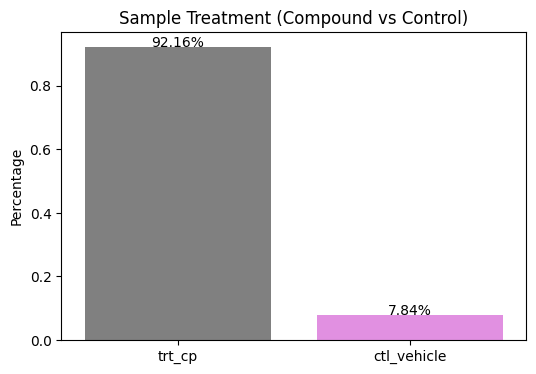

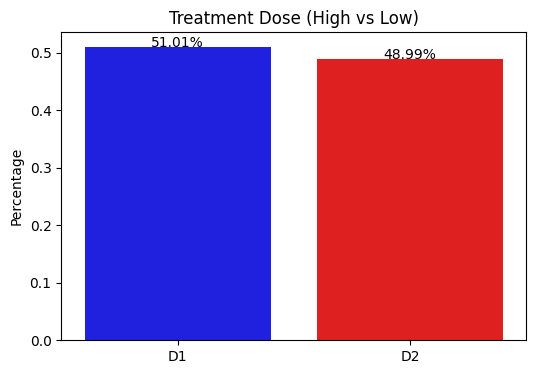

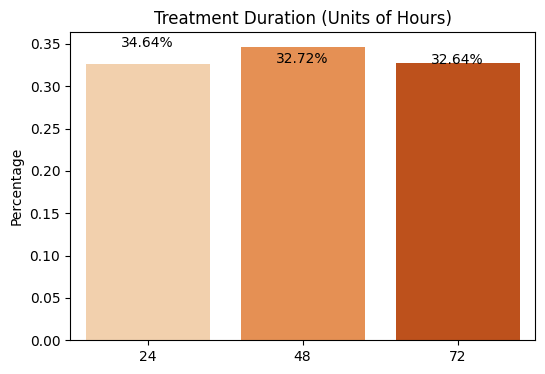

In [11]:
# Function to calculate percentage
def calculate_percentage(data, column):
    counts = data[column].value_counts(normalize=True)
    return pd.DataFrame({column: counts.index, 'Percentage': counts.values})

# Plotting function
def plot_distribution(data, column, title, palette):
    plt.figure(figsize=(6, 4))
    sns.barplot(x=column, y='Percentage', data=data, palette=palette)
    plt.title(title)
    plt.ylabel('Percentage')
    plt.xlabel('')
    for index, value in enumerate(data['Percentage']):
        plt.text(index, value, f'{value:.2%}', ha='center')
    plt.show()

# Calculate percentages
cp_type_dist = calculate_percentage(df_train, 'cp_type')
cp_dose_dist = calculate_percentage(df_train, 'cp_dose')
cp_time_dist = calculate_percentage(df_train, 'cp_time')

# Plot distributions
plot_distribution(cp_type_dist, 'cp_type', 'Sample Treatment (Compound vs Control)', ['grey', 'violet'])
plot_distribution(cp_dose_dist, 'cp_dose', 'Treatment Dose (High vs Low)', ['blue', 'red'])
plot_distribution(cp_time_dist, 'cp_time', 'Treatment Duration (Units of Hours)', 'Oranges')


<Figure size 1000x600 with 0 Axes>

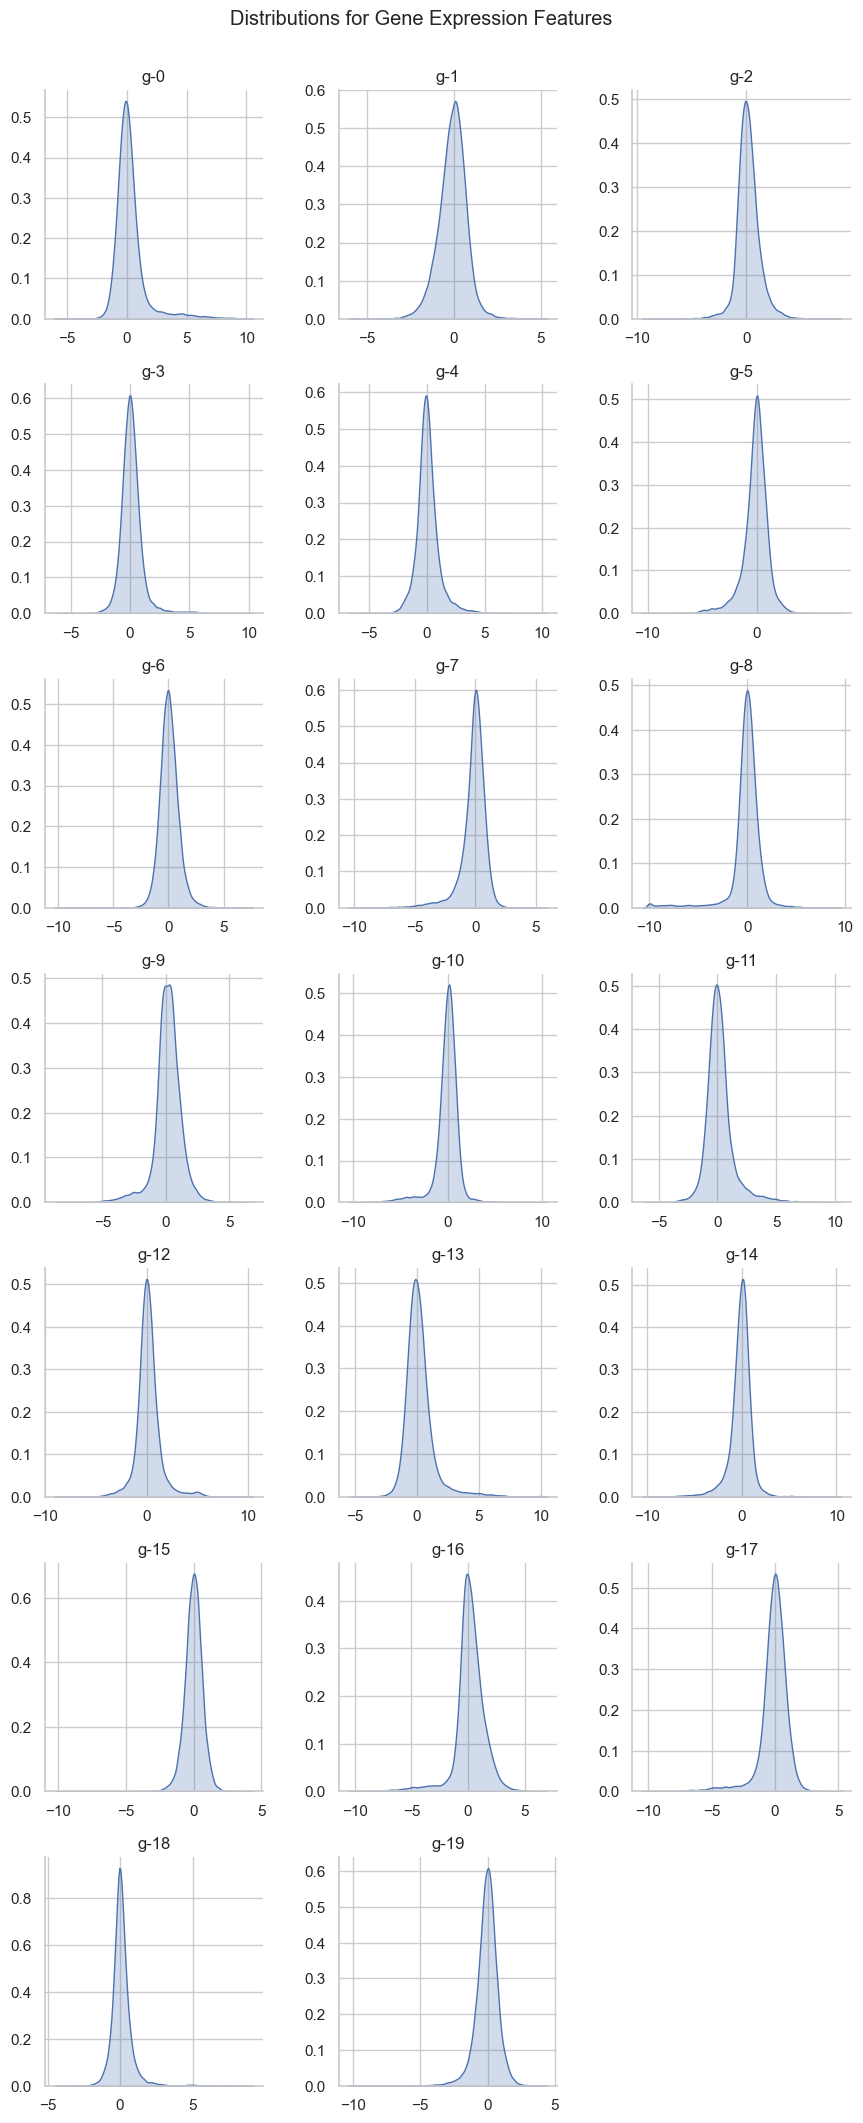

In [12]:
# Selecting the first five gene expression features (g- features)
g_features = [col for col in df_train.columns if col.startswith('g-')]
selected_g_features = g_features[:20]  # Adjust the number as needed
df_selected = df_train[['sig_id'] + selected_g_features]

# Melting the DataFrame
df_melted = df_selected.melt(id_vars=['sig_id'], var_name='feature', value_name='value')

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.despine(left=True)
g = sns.FacetGrid(df_melted, col="feature", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", fill=True)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle("Distributions for Gene Expression Features", y=1.02)
plt.show()


<Figure size 1200x600 with 0 Axes>

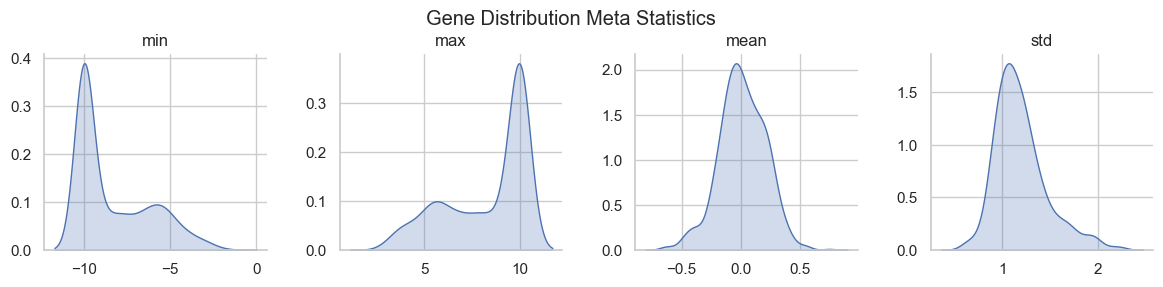

In [13]:
from matplotlib.colors import ListedColormap
# Selecting gene expression features
g_features = [col for col in df_train.columns if col.startswith('g-')]
df_g = df_train[g_features]

# Calculating statistics
stats_df = df_g.agg(['min', 'max', 'mean', 'std']).transpose().reset_index()
stats_df = stats_df.melt(id_vars='index', var_name='stat', value_name='values')

# Creating a custom color palette
# You can choose a different palette as per your preference
palette = ListedColormap(sns.color_palette("husl", 4))

# Plotting
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.despine(left=True)
g = sns.FacetGrid(stats_df, col="stat", sharex=False, sharey=False, palette=palette)
g.map(sns.kdeplot, "values", fill=True)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle("Gene Distribution Meta Statistics", y=1.02)
plt.show()


<Figure size 1000x600 with 0 Axes>

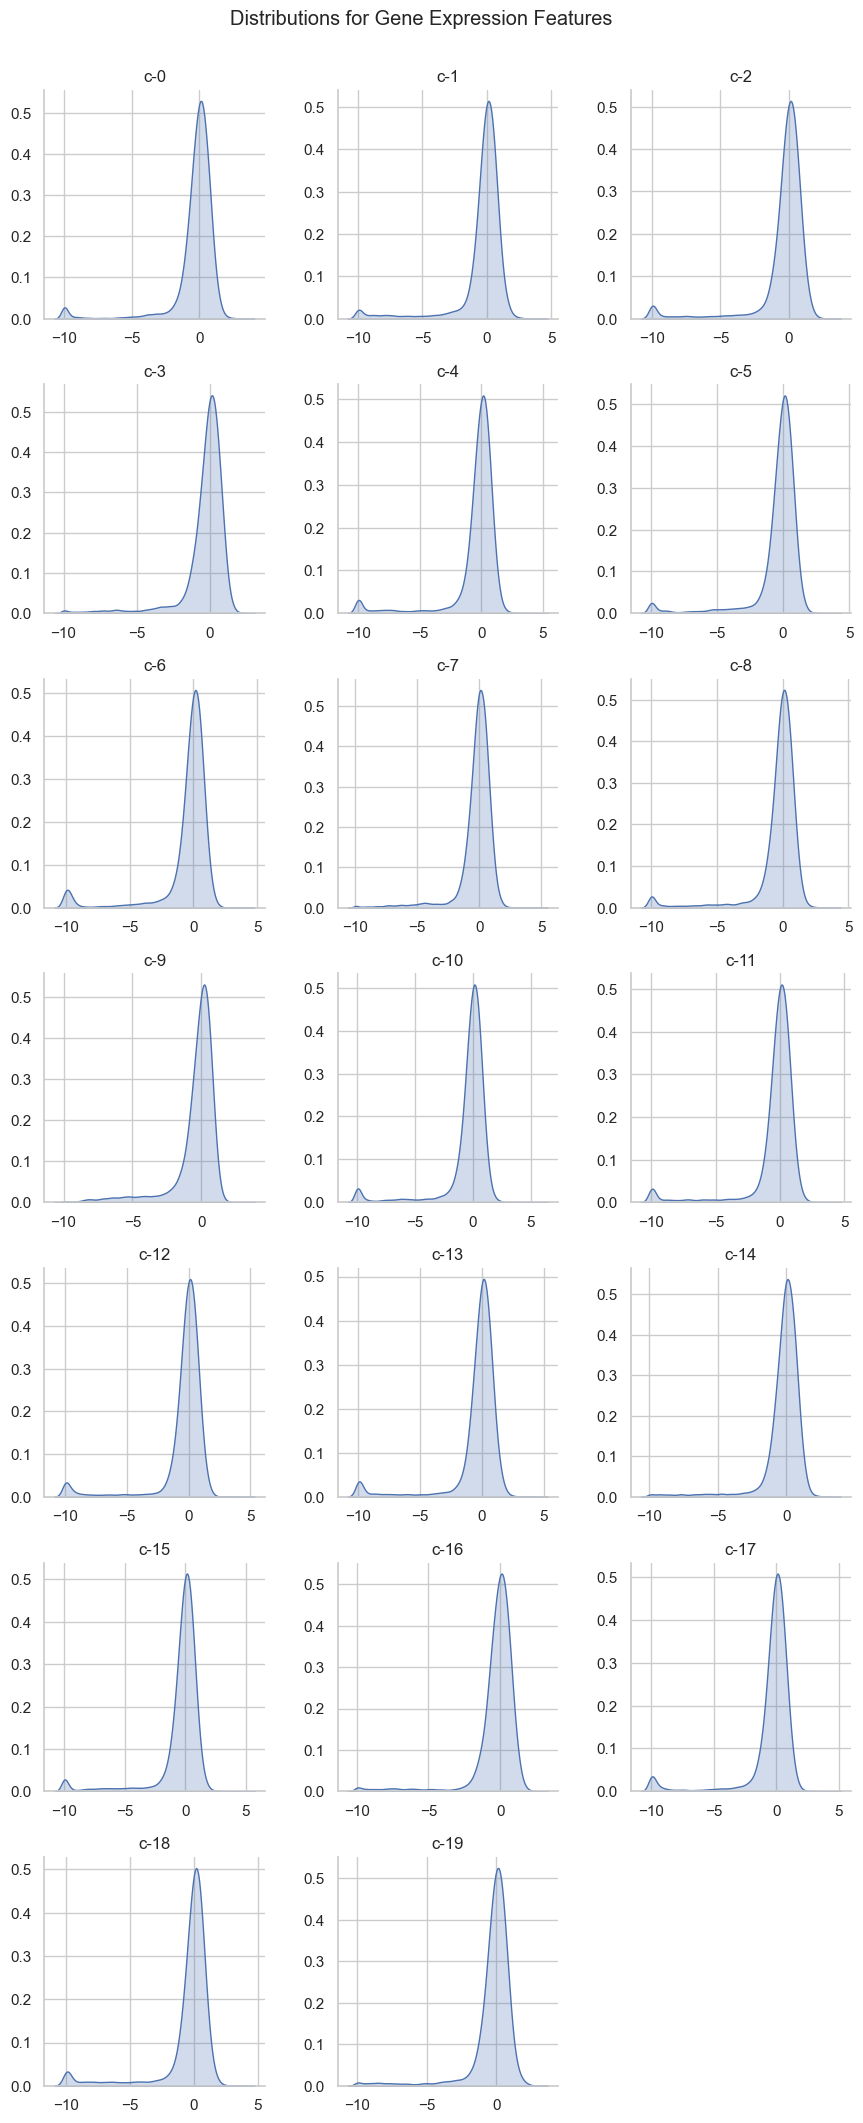

In [14]:
# Selecting the first five gene expression features (g- features)
g_features = [col for col in df_train.columns if col.startswith('c-')]
selected_g_features = g_features[:20]  # Adjust the number as needed
df_selected = df_train[['sig_id'] + selected_g_features]

# Melting the DataFrame
df_melted = df_selected.melt(id_vars=['sig_id'], var_name='feature', value_name='value')

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.despine(left=True)
g = sns.FacetGrid(df_melted, col="feature", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", fill=True)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle("Distributions for Gene Expression Features", y=1.02)
plt.show()

<Figure size 1200x600 with 0 Axes>

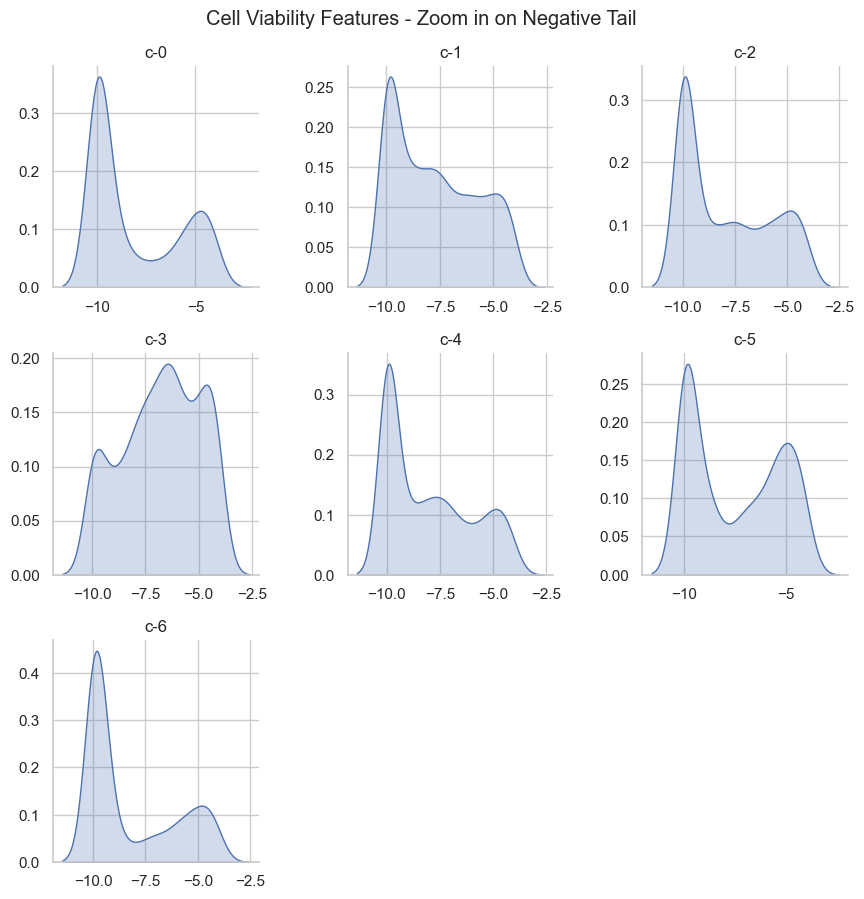

In [15]:
# Selecting the first seven cell viability features (c- features)
c_features = [col for col in df_train.columns if col.startswith('c-')]
selected_c_features = c_features[:7]  # Adjust the number as needed
df_selected = df_train[['sig_id'] + selected_c_features]

# Melting the DataFrame
df_melted = df_selected.melt(id_vars=['sig_id'], var_name='feature', value_name='value')

# Filtering for values less than -4
df_filtered = df_melted[df_melted['value'] < -4]

# Plotting
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.despine(left=True)
g = sns.FacetGrid(df_filtered, col="feature", col_wrap=3, sharex=False, sharey=False, palette="Set3")
g.map(sns.kdeplot, "value", fill=True)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle("Cell Viability Features - Zoom in on Negative Tail", y=1.02)
plt.show()


<Figure size 1200x600 with 0 Axes>

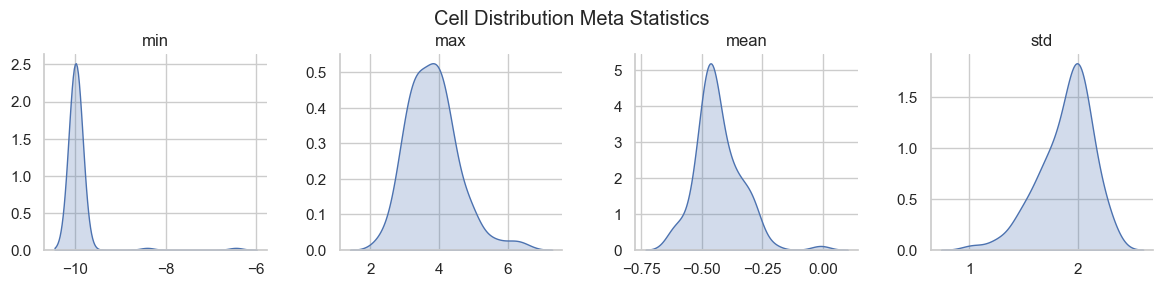

In [16]:
c_features = [col for col in df_train.columns if col.startswith('c-')]
df_c = df_train[c_features]

# Calculating statistics
stats_df = df_c.agg(['min', 'max', 'mean', 'std']).transpose().reset_index()
stats_df = stats_df.melt(id_vars='index', var_name='stat', value_name='values')

# Creating a custom color palette
# You can choose a different palette as per your preference
palette = ListedColormap(sns.color_palette("husl", 4))

# Plotting
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.despine(left=True)
g = sns.FacetGrid(stats_df, col="stat", sharex=False, sharey=False, palette=palette)
g.map(sns.kdeplot, "values", fill=True)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle("Cell Distribution Meta Statistics", y=1.02)
plt.show()


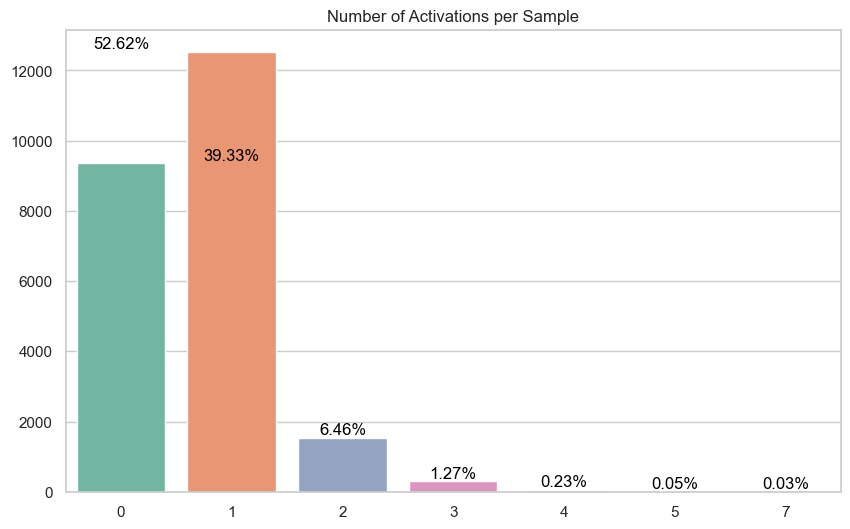

In [17]:
row_sums = df_train_targets_scored.drop('sig_id', axis=1).sum(axis=1)
row_stats = pd.DataFrame({'sum': row_sums})

# Counting the occurrences of each sum
count_sums = row_stats['sum'].value_counts().reset_index()
count_sums.columns = ['sum', 'n']
count_sums['total'] = count_sums['n'].sum()
count_sums['perc'] = count_sums['n'] / count_sums['total']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='sum', y='n', data=count_sums, palette='Set2')
plt.title("Number of Activations per Sample")
plt.xlabel('')
plt.ylabel('')

# Adding percentage labels
for index, row in count_sums.iterrows():
    plt.text(index, row['n'], f'{row["perc"]:.2%}', color='black', ha="center", va="bottom")

plt.show()


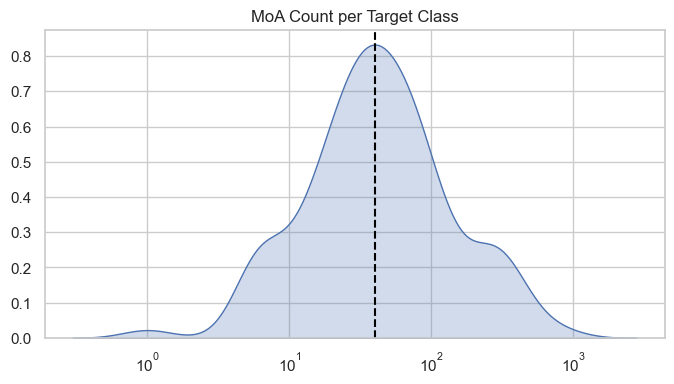

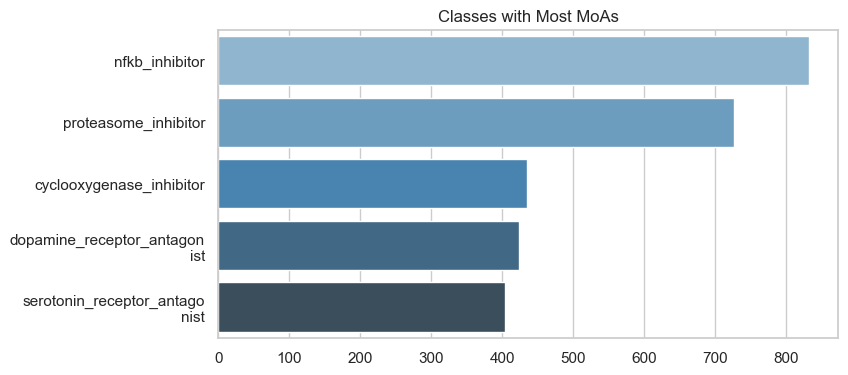

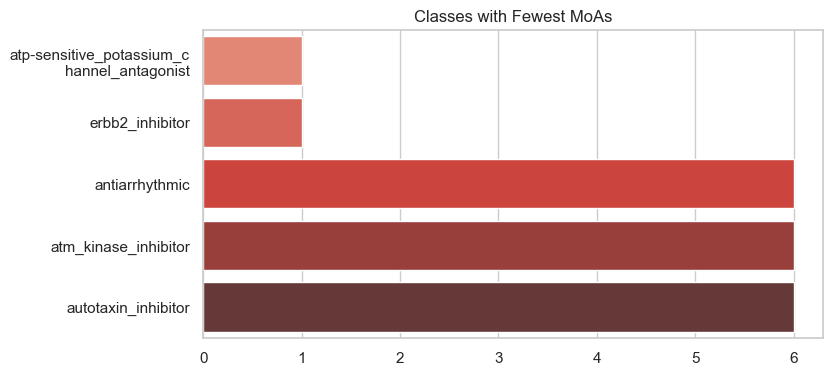

In [18]:
from textwrap import wrap
target_sums = df_train_targets_scored.drop('sig_id', axis=1).sum().reset_index()
target_sums.columns = ['target', 'sum']

# Plot 1: Density plot of MoA counts per target class
plt.figure(figsize=(8, 4))
sns.kdeplot(data=target_sums, x='sum', fill='darkorange', log_scale=True)
plt.axvline(x=40, color='black', linestyle='--')
plt.title("MoA Count per Target Class")
plt.xlabel('')
plt.ylabel('')
plt.show()

# Plot 2: Top 5 classes with the most MoAs
top_5 = target_sums.nlargest(5, 'sum')
top_5['target'] = ['\n'.join(wrap(t, 25)) for t in top_5['target']]
plt.figure(figsize=(8, 4))
sns.barplot(x='sum', y='target', data=top_5, palette='Blues_d')
plt.title("Classes with Most MoAs")
plt.xlabel('')
plt.ylabel('')
plt.show()

# Plot 3: Top 5 classes with the fewest MoAs
bottom_5 = target_sums.nsmallest(5, 'sum')
bottom_5['target'] = ['\n'.join(wrap(t, 25)) for t in bottom_5['target']]
plt.figure(figsize=(8, 4))
sns.barplot(x='sum', y='target', data=bottom_5, palette='Reds_d')
plt.title("Classes with Fewest MoAs")
plt.xlabel('')
plt.ylabel('')
plt.show()


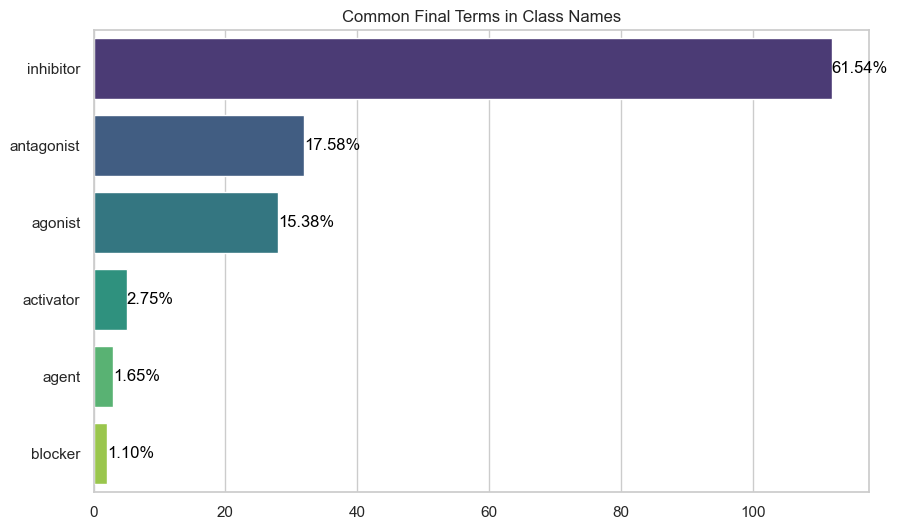

In [19]:

from textwrap import wrap
target_sums = df_train_targets_scored.drop('sig_id', axis=1).sum().reset_index()
target_sums.columns = ['target', 'sum']
target_sums['type'] = target_sums['target'].apply(lambda x: x.split('_')[-1])

# Counting occurrences of each final term
type_counts = target_sums['type'].value_counts().reset_index()
type_counts.columns = ['type', 'n']
type_counts = type_counts[type_counts['n'] > 1]
type_counts['total'] = type_counts['n'].sum()
type_counts['perc'] = type_counts['n'] / type_counts['total']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='n', y='type', data=type_counts, palette='viridis')
plt.title("Common Final Terms in Class Names")
plt.xlabel('')
plt.ylabel('')

# Adding percentage labels
for index, row in type_counts.iterrows():
    plt.text(row['n'], index, f'{row["perc"]:.2%}', color='black', ha="left", va="center")

plt.show()


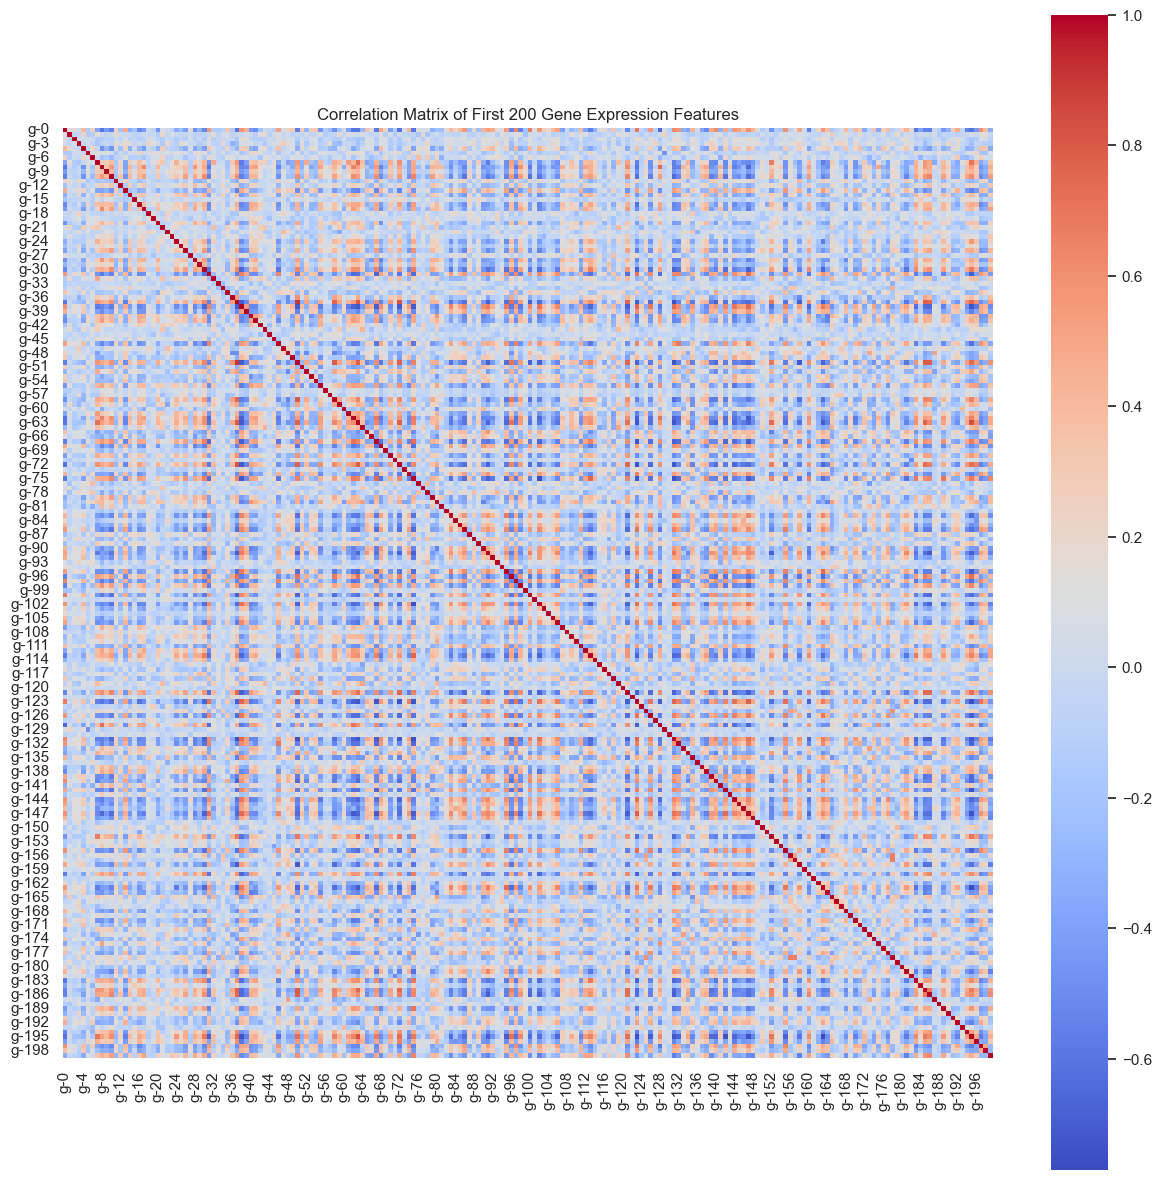

In [20]:
g_features = [col for col in df_train.columns if col.startswith('g-')]
selected_g_features = g_features[:200]  # Adjust the number as needed
df_g = df_train[selected_g_features]

# Calculating the Pearson correlation matrix
corr_matrix = df_g.corr(method='pearson')

# Plotting the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0, linecolor='black', square=True)
plt.title("Correlation Matrix of First 200 Gene Expression Features")
plt.show()


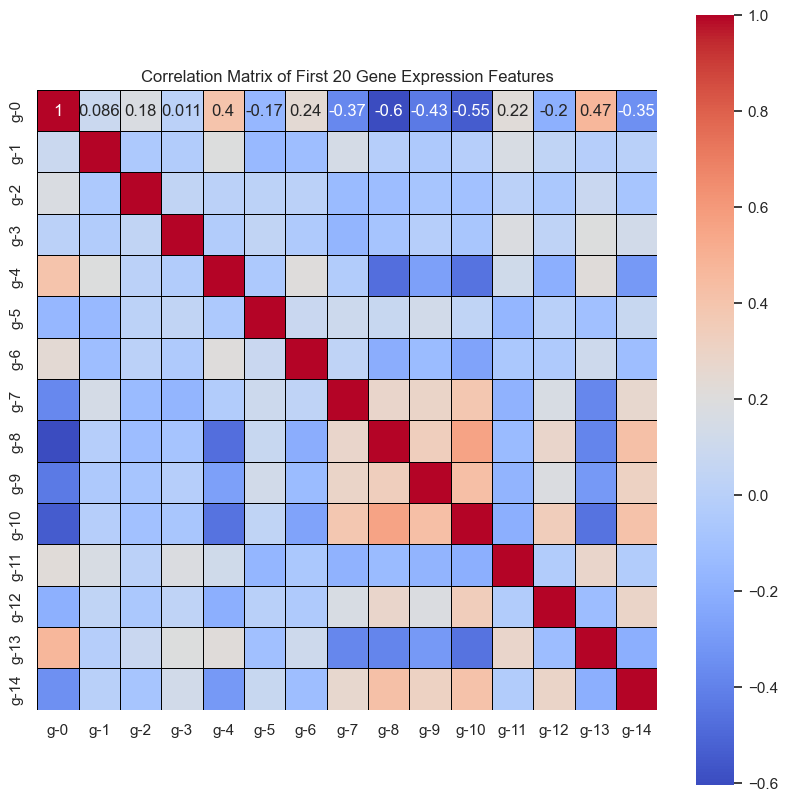

In [21]:
g_features = [col for col in df_train.columns if col.startswith('g-')]
selected_g_features = g_features[:15]  # Adjust the number as needed
df_g = df_train[selected_g_features]

# Calculating the Pearson correlation matrix
corr_matrix = df_g.corr(method='pearson')

# Plotting the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', square=True)
plt.title("Correlation Matrix of First 20 Gene Expression Features")
plt.show()

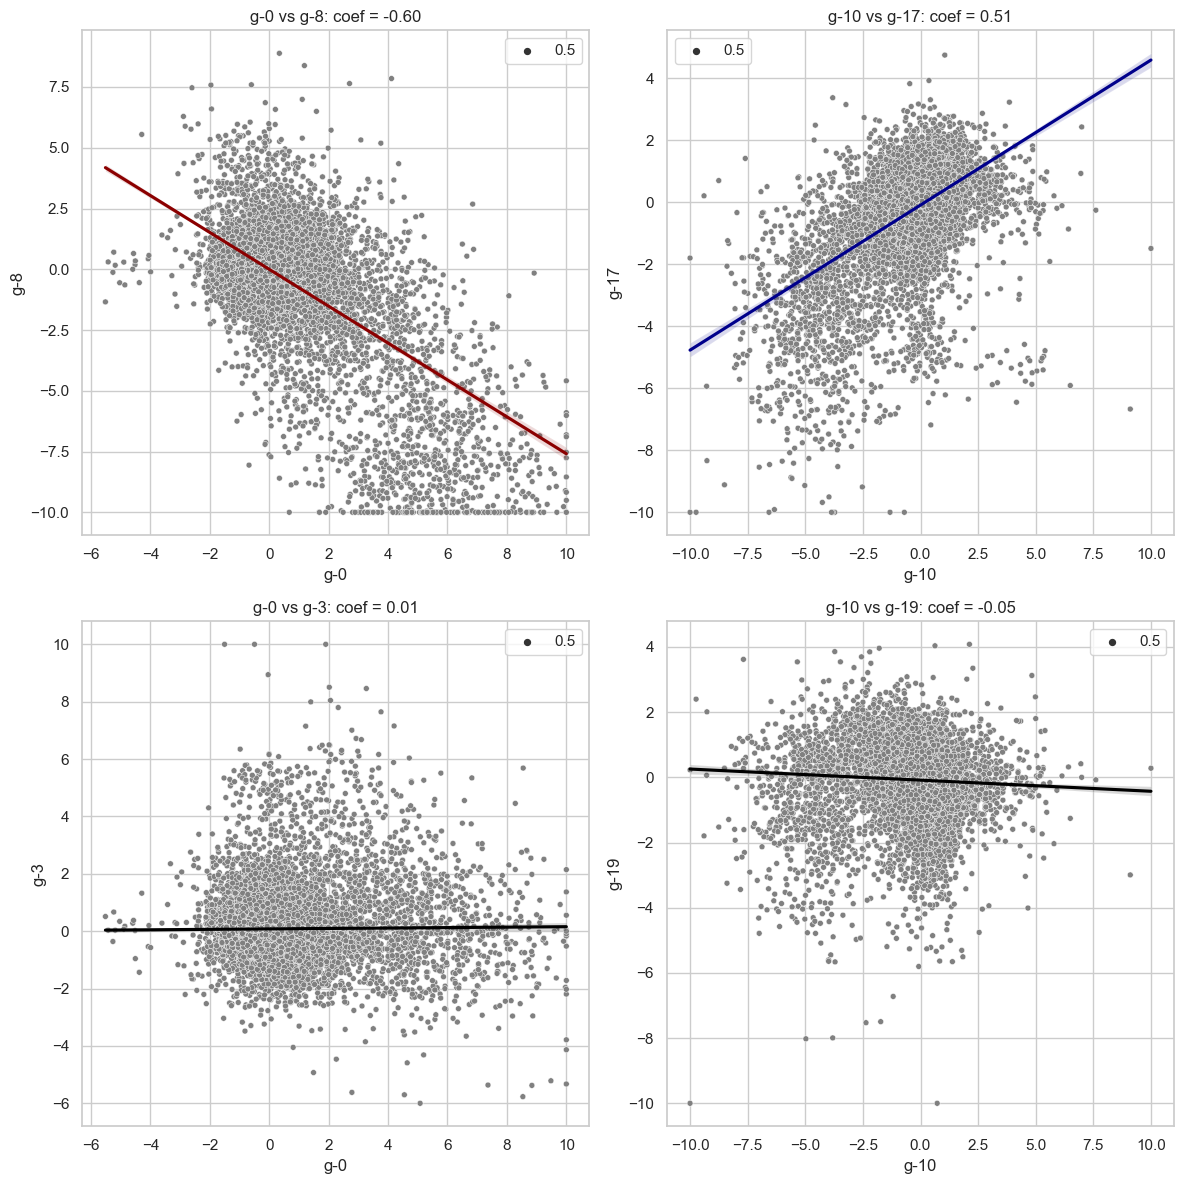

In [22]:
def plot_scatter(df, x, y, ax, color):
    sns.scatterplot(x=x, y=y, data=df, color="grey", size=0.5, ax=ax)
    sns.regplot(x=x, y=y, data=df, scatter=False, color=color, ax=ax)
    correlation = df[[x, y]].corr().iloc[0, 1]
    ax.set_title(f"{x} vs {y}: coef = {correlation:.2f}")

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plotting each pair
plot_scatter(df_train, 'g-0', 'g-8', axs[0, 0], 'darkred')
plot_scatter(df_train, 'g-10', 'g-17', axs[0, 1], 'darkblue')
plot_scatter(df_train, 'g-0', 'g-3', axs[1, 0], 'black')
plot_scatter(df_train, 'g-10', 'g-19', axs[1, 1], 'black')

plt.tight_layout()
plt.show()

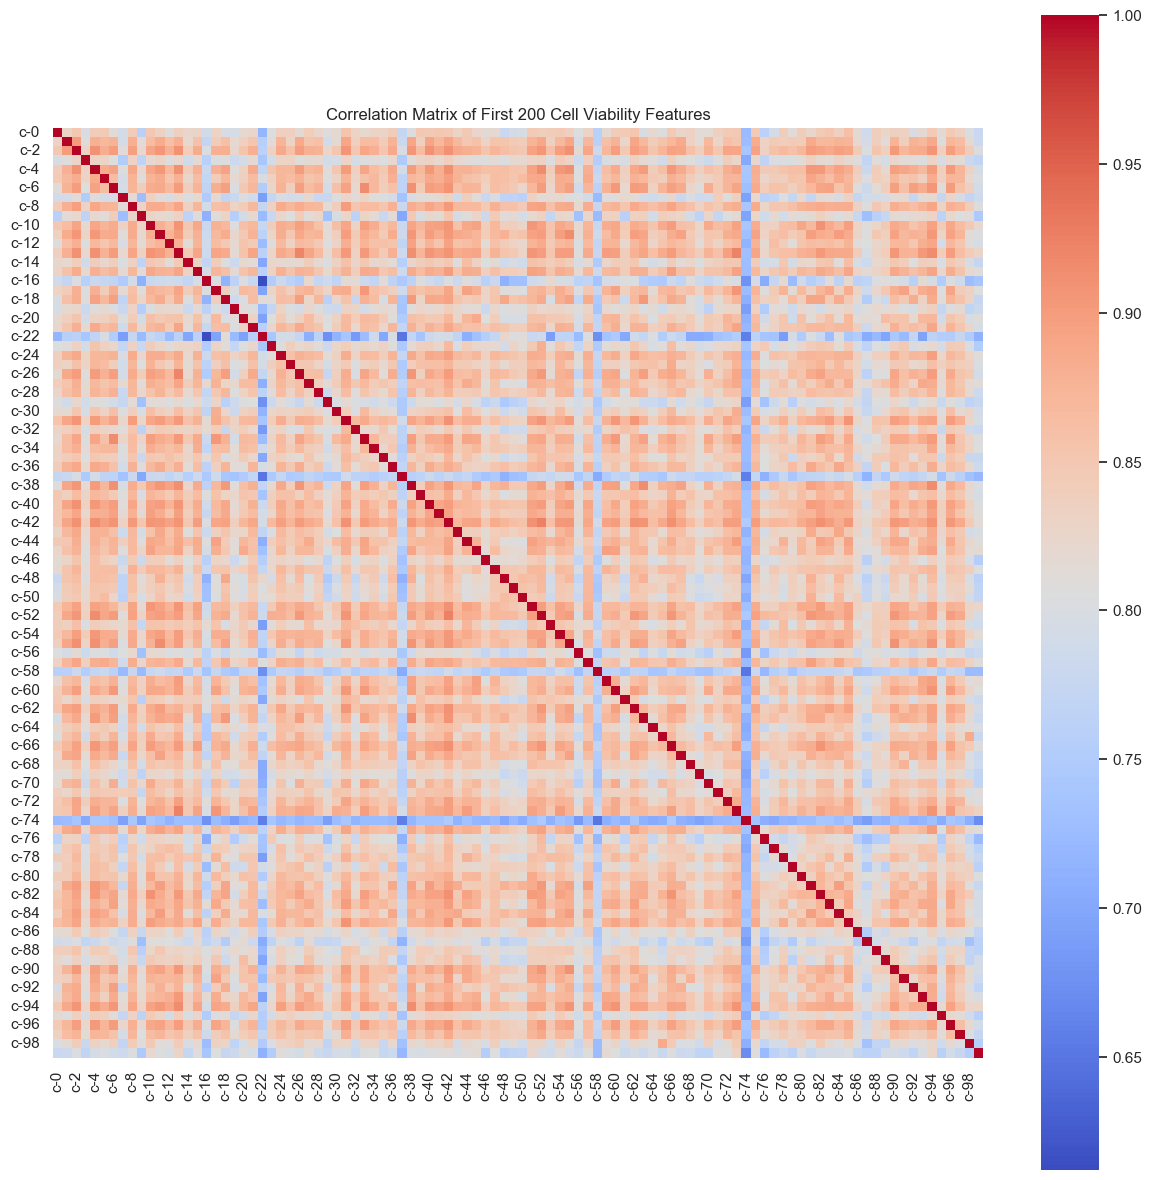

In [23]:
c_features = [col for col in df_train.columns if col.startswith('c-')]
selected_c_features = c_features[:200]  # Adjust the number as needed
df_c = df_train[selected_c_features]

# Calculating the Pearson correlation matrix
corr_matrix = df_c.corr(method='pearson')

# Plotting the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0, linecolor='black', square=True)
plt.title("Correlation Matrix of First 200 Cell Viability Features")
plt.show()

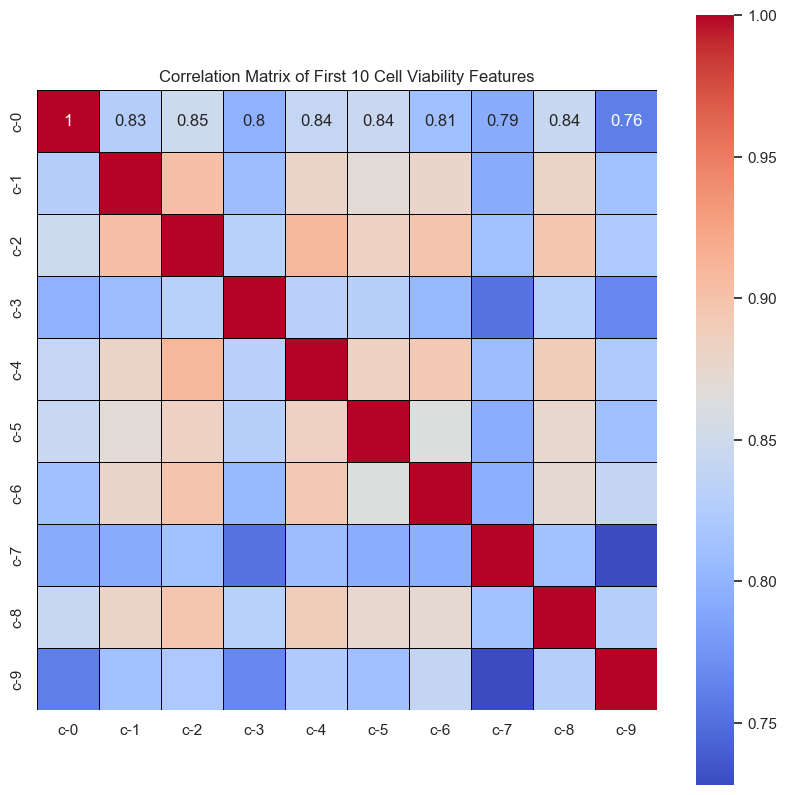

In [24]:
c_features = [col for col in df_train.columns if col.startswith('c-')]
selected_c_features = c_features[:10]  # Adjust the number as needed
df_c = df_train[selected_c_features]

corr_matrix = df_c.corr(method='pearson')

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', square=True)
plt.title("Correlation Matrix of First 10 Cell Viability Features")
plt.show()


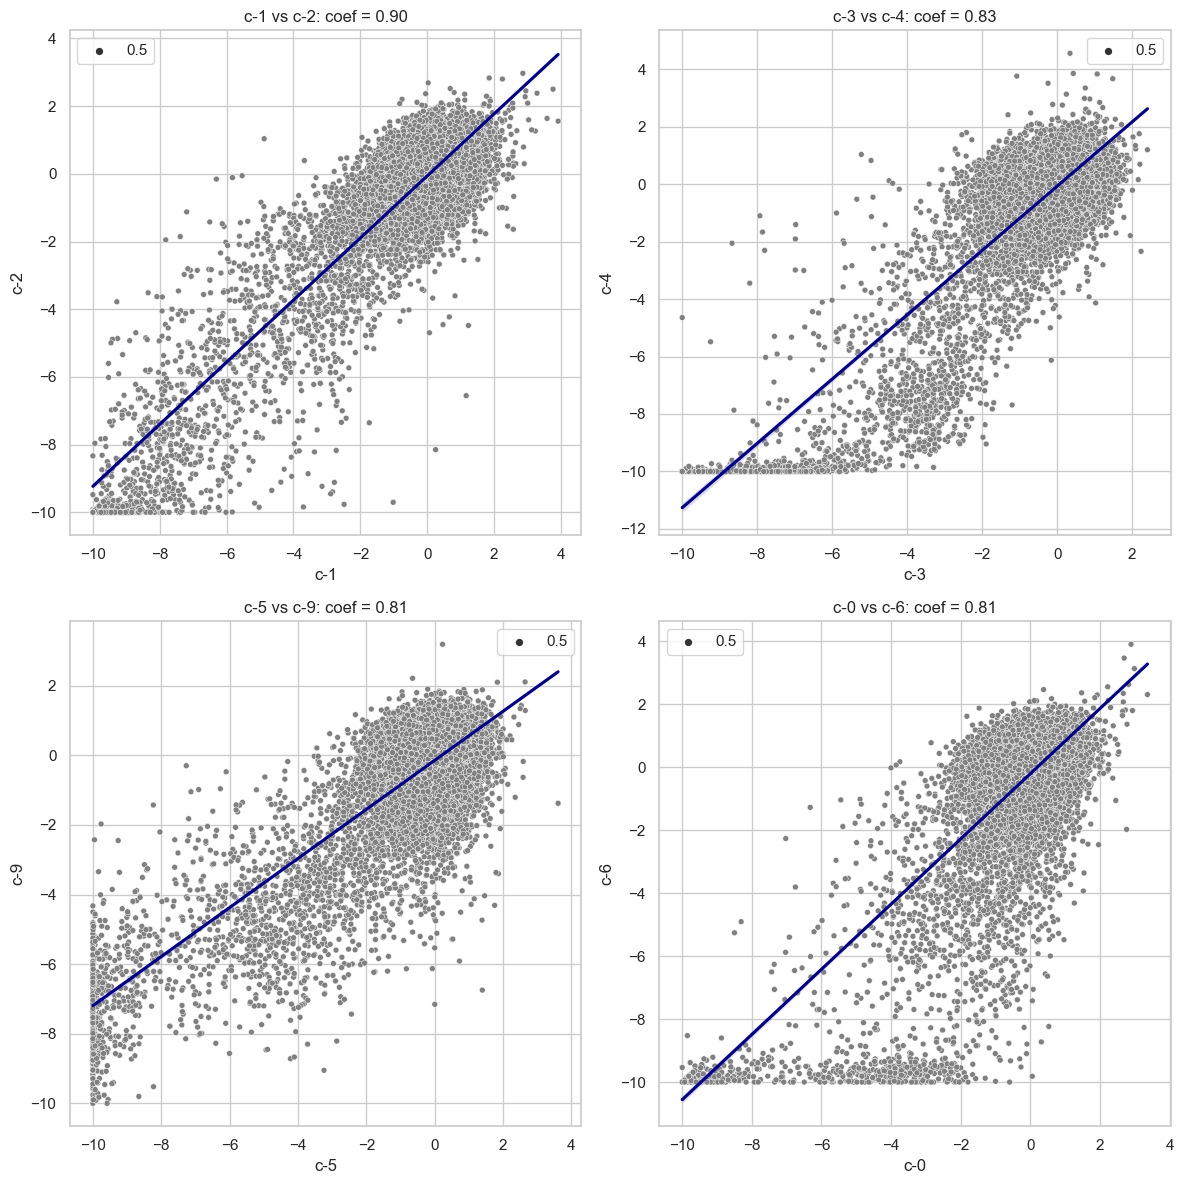

In [25]:
# Function to create a scatter plot with linear regression line
def plot_scatter(df, x, y, ax, color):
    sns.scatterplot(x=x, y=y, data=df, color="grey", size=0.5, ax=ax)
    sns.regplot(x=x, y=y, data=df, scatter=False, color=color, ax=ax)
    correlation = df[[x, y]].corr().iloc[0, 1]
    ax.set_title(f"{x} vs {y}: coef = {correlation:.2f}")

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plotting each pair
plot_scatter(df_train, 'c-1', 'c-2', axs[0, 0], 'darkblue')
plot_scatter(df_train, 'c-3', 'c-4', axs[0, 1], 'darkblue')
plot_scatter(df_train, 'c-5', 'c-9', axs[1, 0], 'darkblue')
plot_scatter(df_train, 'c-0', 'c-6', axs[1, 1], 'darkblue')

plt.tight_layout()
plt.show()

C:\Users\manke\AppData\Local\Temp/ipykernel_32352/1877907352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['sum'] = df_train[target_features_scored].sum(axis=1)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx a

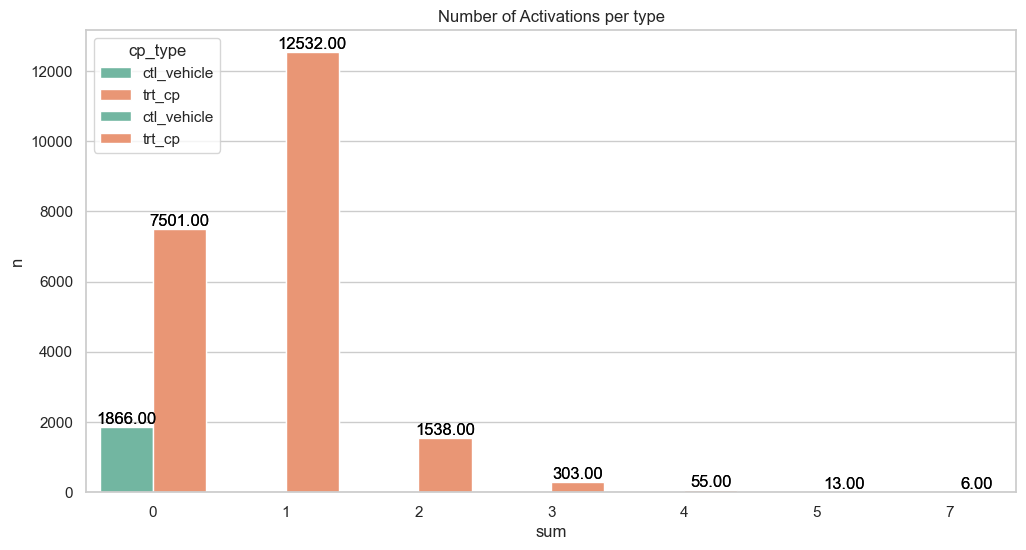

In [26]:
# Selecting specific columns
cp_cols = [col for col in df_train.columns if col.startswith('cp')]
g_cols = ['g-8', 'g-525']
c_cols = ['c-14', 'c-42']
selected_columns = cp_cols + g_cols + c_cols
df_selected = df_train[selected_columns]

# Assuming sum is a sum of certain activations - you need to define this
# For example, if sum is the sum of all target features
df_selected['sum'] = df_train[target_features_scored].sum(axis=1)

# Grouping and calculating percentages
grouped = df_selected.groupby(['cp_type', 'sum']).size().reset_index(name='n')
grouped['total'] = grouped.groupby('cp_type')['n'].transform('sum')
grouped['perc'] = grouped['n'] / grouped['total']

# Creating the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='sum', y='n', hue='cp_type', data=grouped, palette='Set2')
plt.title('Number of Activations per type')
plt.xlabel('')
plt.ylabel('')

# Adding percentage text
for p in sns.barplot(x='sum', y='n', hue='cp_type', data=grouped, palette='Set2').patches:
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.2f}', 
             fontsize=12, color='black', ha='center', va='bottom')
plt.show()


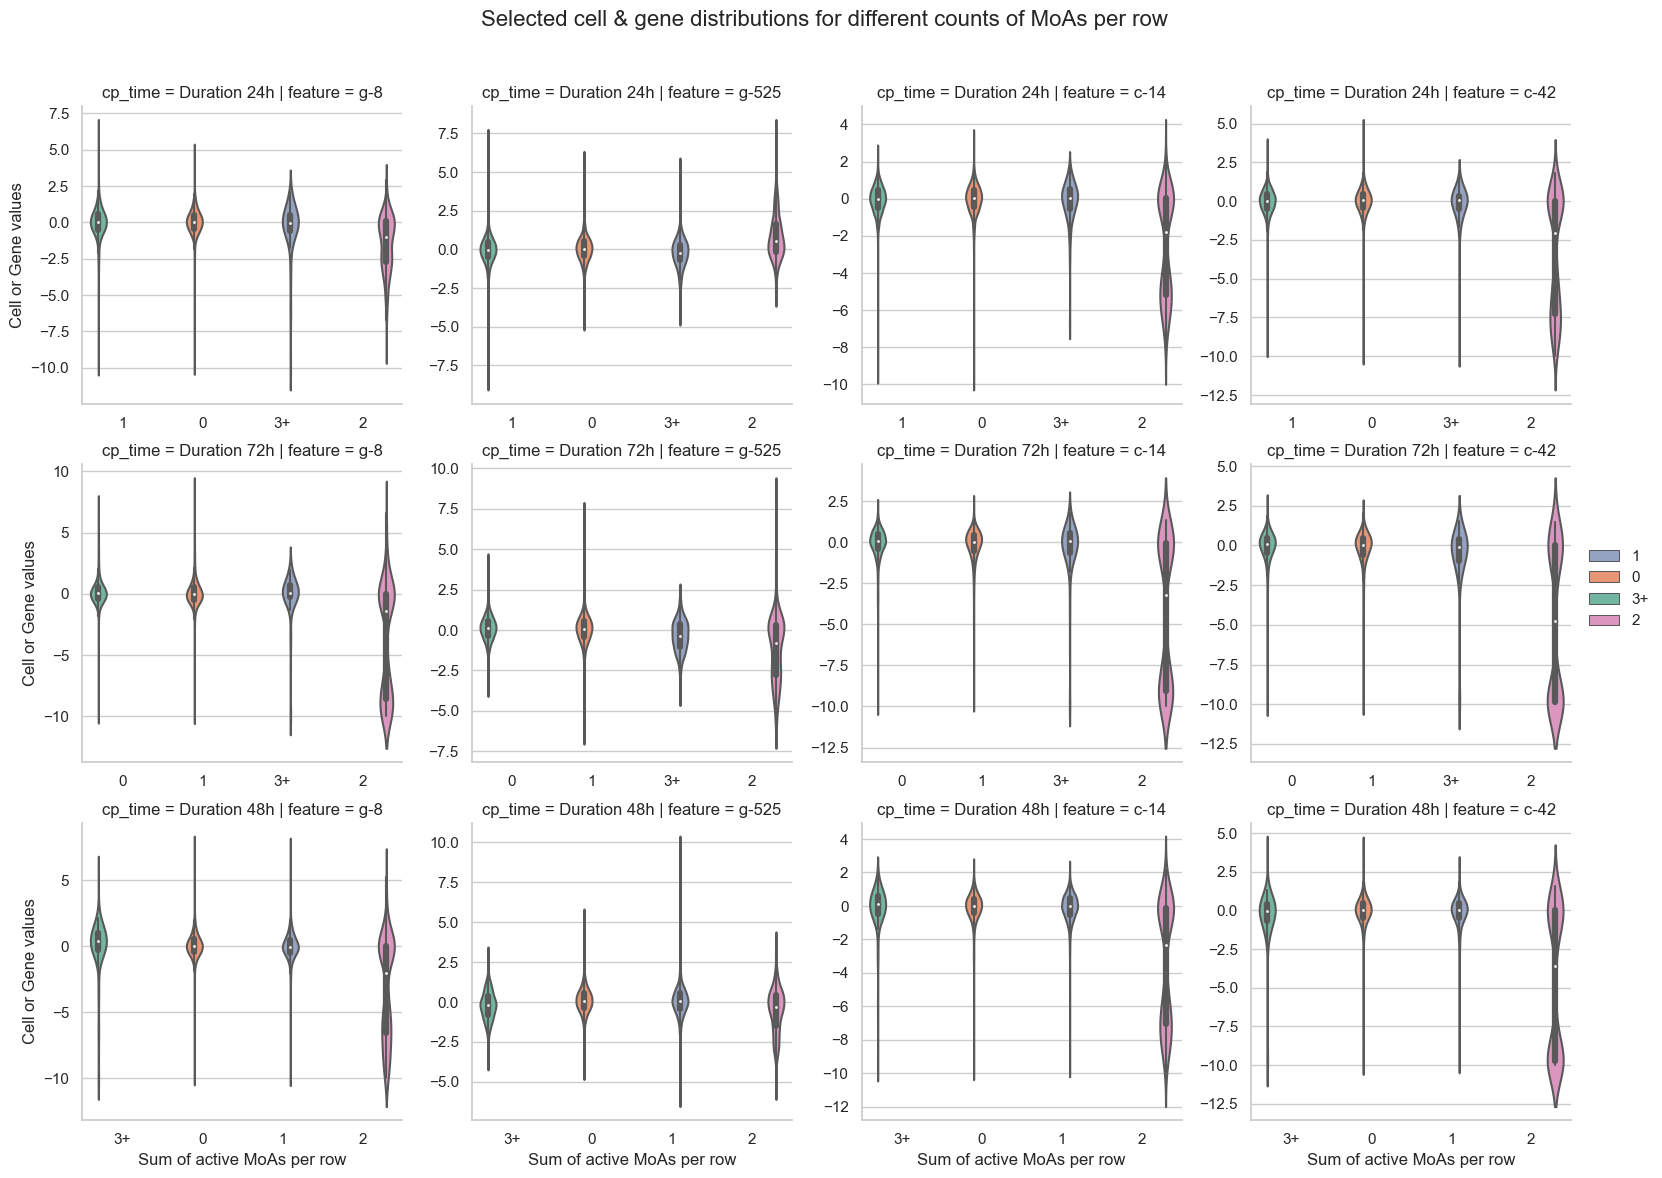

In [27]:
df_trt_cp = df_selected[df_selected['cp_type'] == 'trt_cp'].copy()

# Modify cp_time and sum
df_trt_cp['cp_time'] = 'Duration ' + df_trt_cp['cp_time'].astype(str) + 'h'
df_trt_cp['sum'] = df_trt_cp['sum'].apply(lambda x: '3+' if x >= 3 else str(x))

# Melt the dataframe to long format
df_melted = df_trt_cp.melt(id_vars=['cp_time', 'sum'], value_vars=g_cols + c_cols, 
                           var_name='feature', value_name='value')

# Creating the violin plots
g = sns.FacetGrid(df_melted, col='feature', row='cp_time', sharex=False, sharey=False, height=4, aspect=1)
g = g.map(sns.violinplot, 'sum', 'value', 'sum', palette='Set2', split=False).add_legend()

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Selected cell & gene distributions for different counts of MoAs per row', fontsize=16)
g.set_axis_labels("Sum of active MoAs per row", "Cell or Gene values")
plt.show()


## Feature Reduction using PCA

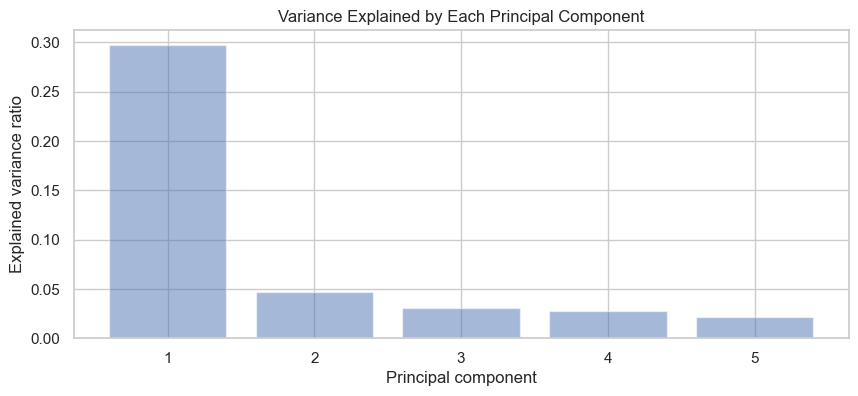

In [28]:
X = df_train.filter(regex='^g-')

# Performing PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Scree Plot
plt.figure(figsize=(10, 4))
explained_variance = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.title('Variance Explained by Each Principal Component')
plt.show()

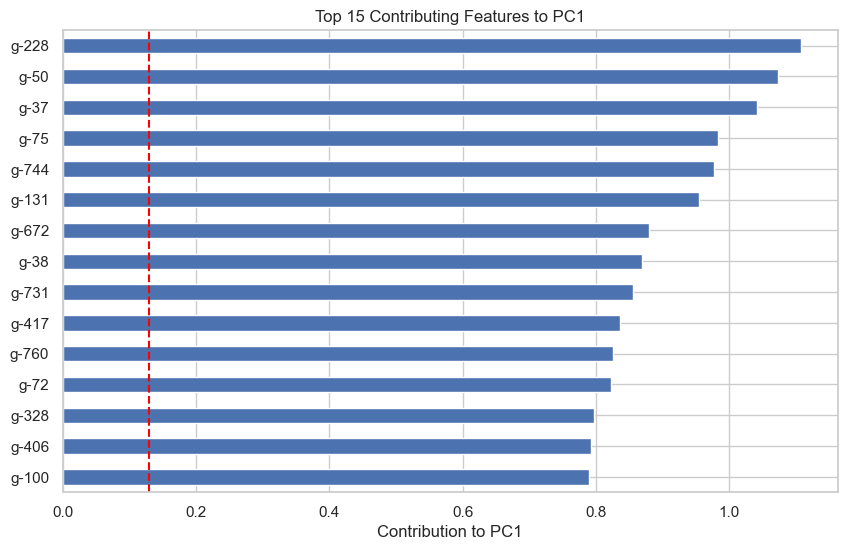

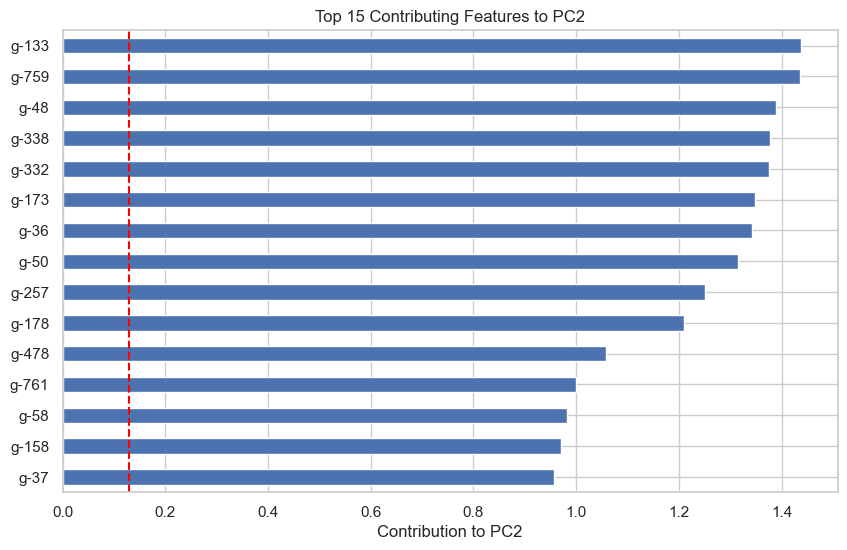

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate contributions of each variable to the PCs
contributions = np.square(pca.components_) * 100

# Function to plot top contributing features for a given PC
def plot_top_contributors(pc, n_top, pc_number):
    top_contributors = pd.Series(contributions[pc_number], index=X.columns).nlargest(n_top)
    top_contributors.sort_values().plot(kind='barh', figsize=(10, 6))
    plt.xlabel('Contribution to PC' + str(pc_number + 1))
    plt.title(f'Top {n_top} Contributing Features to PC{pc_number + 1}')
    plt.axvline(x=100/len(X.columns), color='red', linestyle='--')  # Expected value for uniform distribution
    plt.show()

# Plot for PC1
plot_top_contributors(contributions, 15, 0)

# Plot for PC2
plot_top_contributors(contributions, 15, 1)

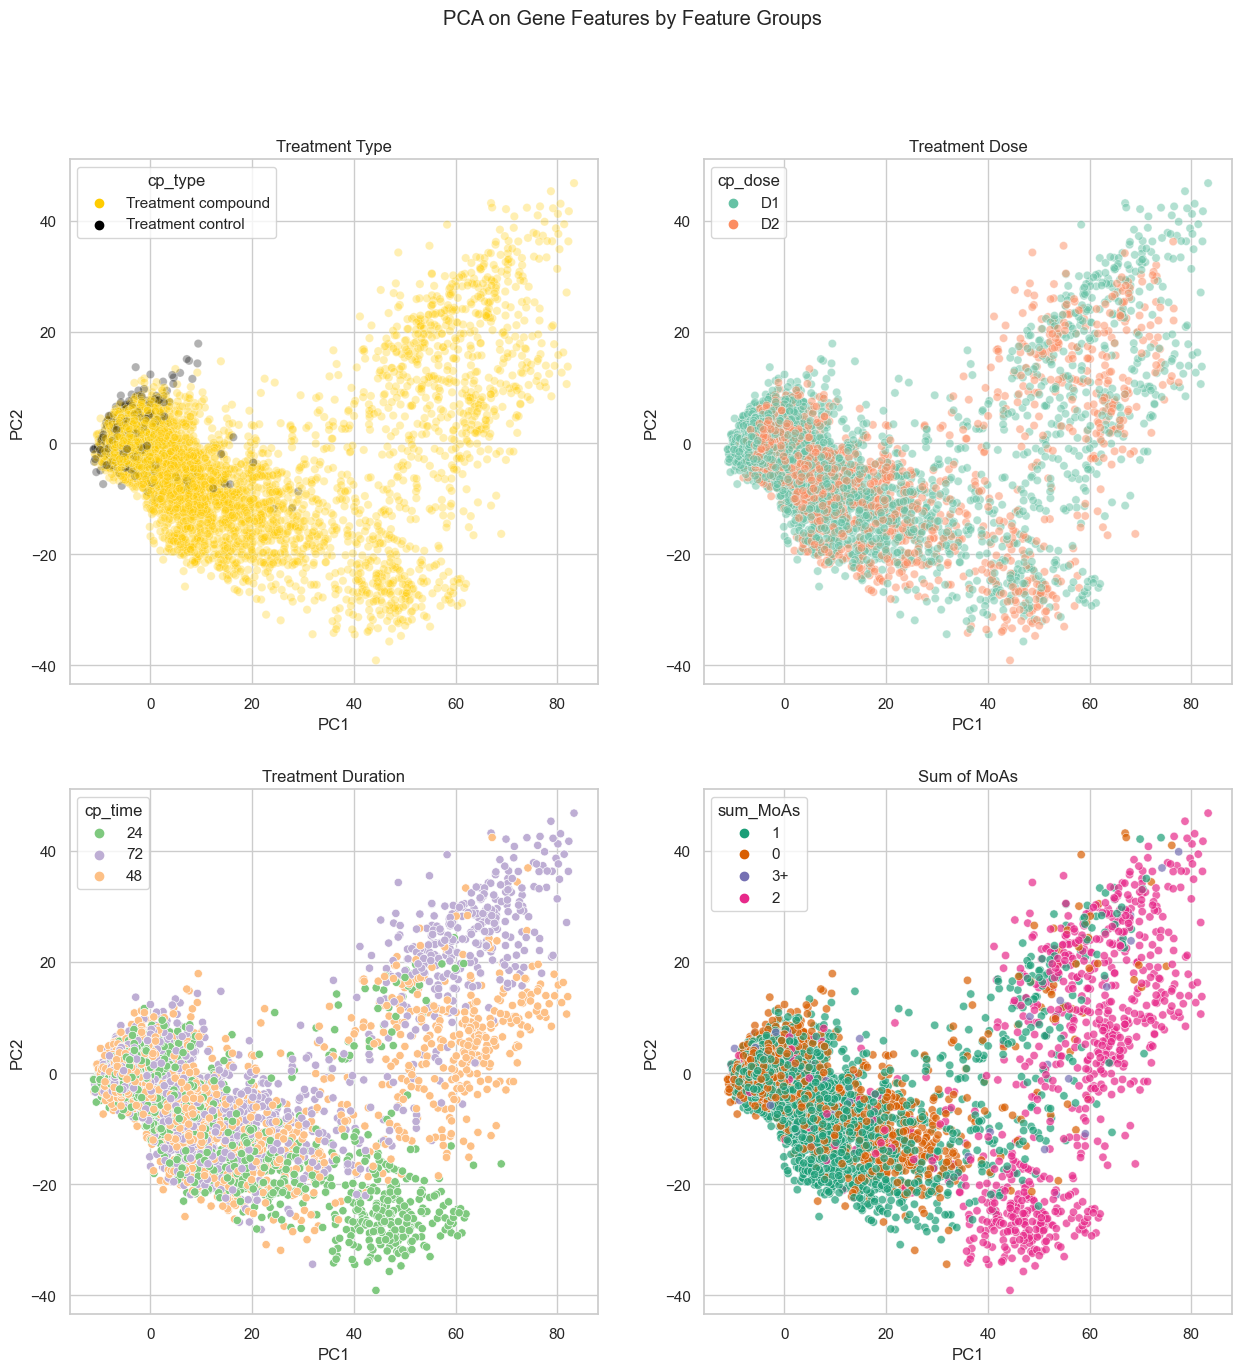

In [30]:
# Prepare the data
X_scaled = StandardScaler().fit_transform(X)  # Standardize features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2'])
df_pca['cp_type'] = df_train['cp_type'].map({'trt_cp': 'Treatment compound', 'ctl_vehicle': 'Treatment control'})
df_pca['cp_dose'] = df_train['cp_dose']
df_pca['cp_time'] = df_train['cp_time'].astype(str)

# Assuming you have a way to calculate the 'sum' of MoAs
# For example, if 'sum' is the sum of certain target features
df_pca['sum_MoAs'] = df_train[target_features_scored].sum(axis=1).apply(lambda x: '3+' if x >= 3 else str(x))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Treatment type
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cp_type', alpha=0.3, ax=axs[0, 0], palette=["#FFCC00", "black"])
axs[0, 0].set_title('Treatment Type')

# Treatment dose
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cp_dose', alpha=0.5, ax=axs[0, 1], palette="Set2")
axs[0, 1].set_title('Treatment Dose')

# Treatment duration
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cp_time', alpha=1, ax=axs[1, 0], palette="Accent")
axs[1, 0].set_title('Treatment Duration')

# Sum of MoAs
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sum_MoAs', alpha=0.7, ax=axs[1, 1], palette="Dark2")
axs[1, 1].set_title('Sum of MoAs')

plt.suptitle('PCA on Gene Features by Feature Groups')
plt.show()


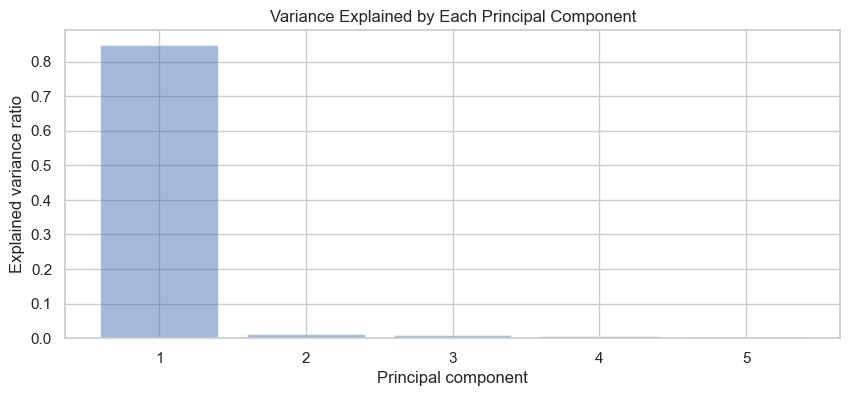

In [31]:
Xc = df_train.filter(regex='^c-')

# Performing PCA
pca_cell = PCA(n_components=5)
Xc_pca = pca_cell.fit_transform(Xc)

# Scree Plot
plt.figure(figsize=(10, 4))
explained_variance = pca_cell.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.title('Variance Explained by Each Principal Component')
plt.show()



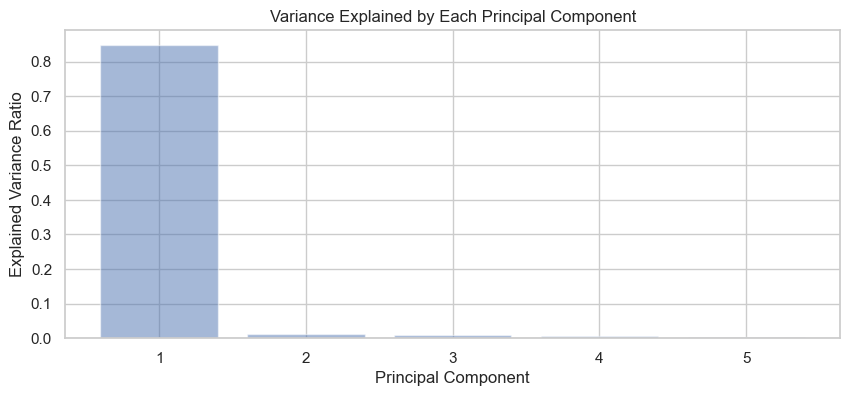

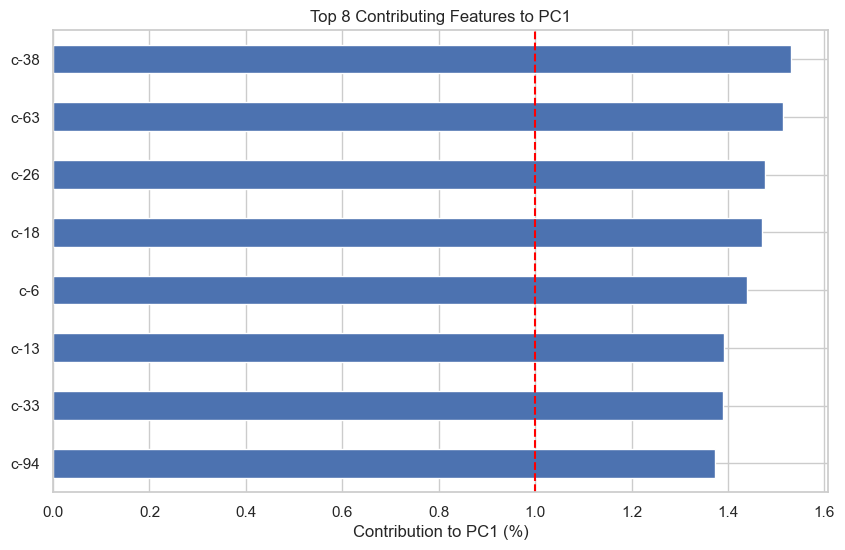

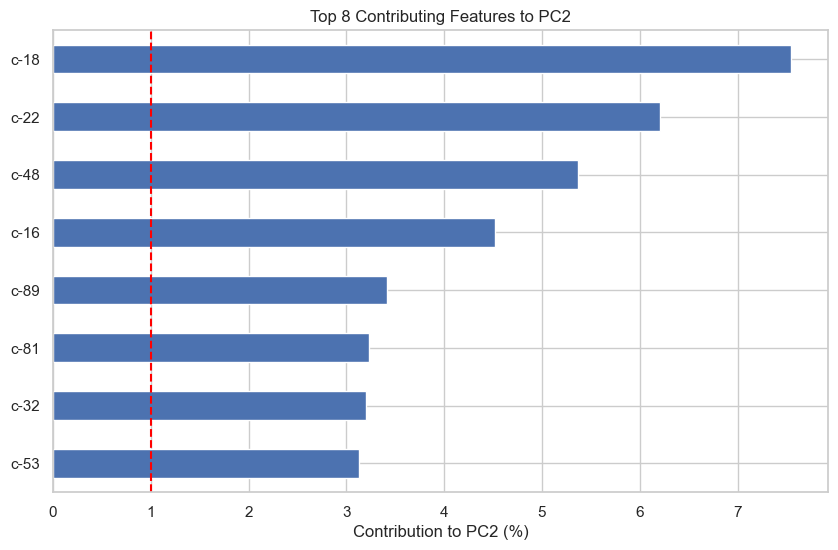

In [32]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Selecting columns that start with "c-"
Xc = df_train.filter(regex='^c-')

# Performing PCA
pca_cell = PCA(n_components=5)
Xc_pca = pca_cell.fit_transform(Xc)

# Scree Plot (Variance Explained)
plt.figure(figsize=(10, 4))
explained_variance = pca_cell.explained_variance_ratio_
plt.bar(range(1, 6), explained_variance[:5], alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Variance Explained by Each Principal Component')
plt.show()

# Top Contributing Variables to PC1 and PC2
def plot_top_contributors(pc, n_top, pc_number):
    top_contributors = pd.Series(np.square(pc[pc_number]) * 100, index=Xc.columns).nlargest(n_top)
    top_contributors.sort_values().plot(kind='barh', figsize=(10, 6))
    plt.xlabel(f'Contribution to PC{pc_number + 1} (%)')
    plt.title(f'Top {n_top} Contributing Features to PC{pc_number + 1}')
    plt.axvline(x=100/len(Xc.columns), color='red', linestyle='--')  # Expected uniform distribution value
    plt.show()

# Plot for PC1
plot_top_contributors(pca_cell.components_, 8, 0)

# Plot for PC2
plot_top_contributors(pca_cell.components_, 8, 1)


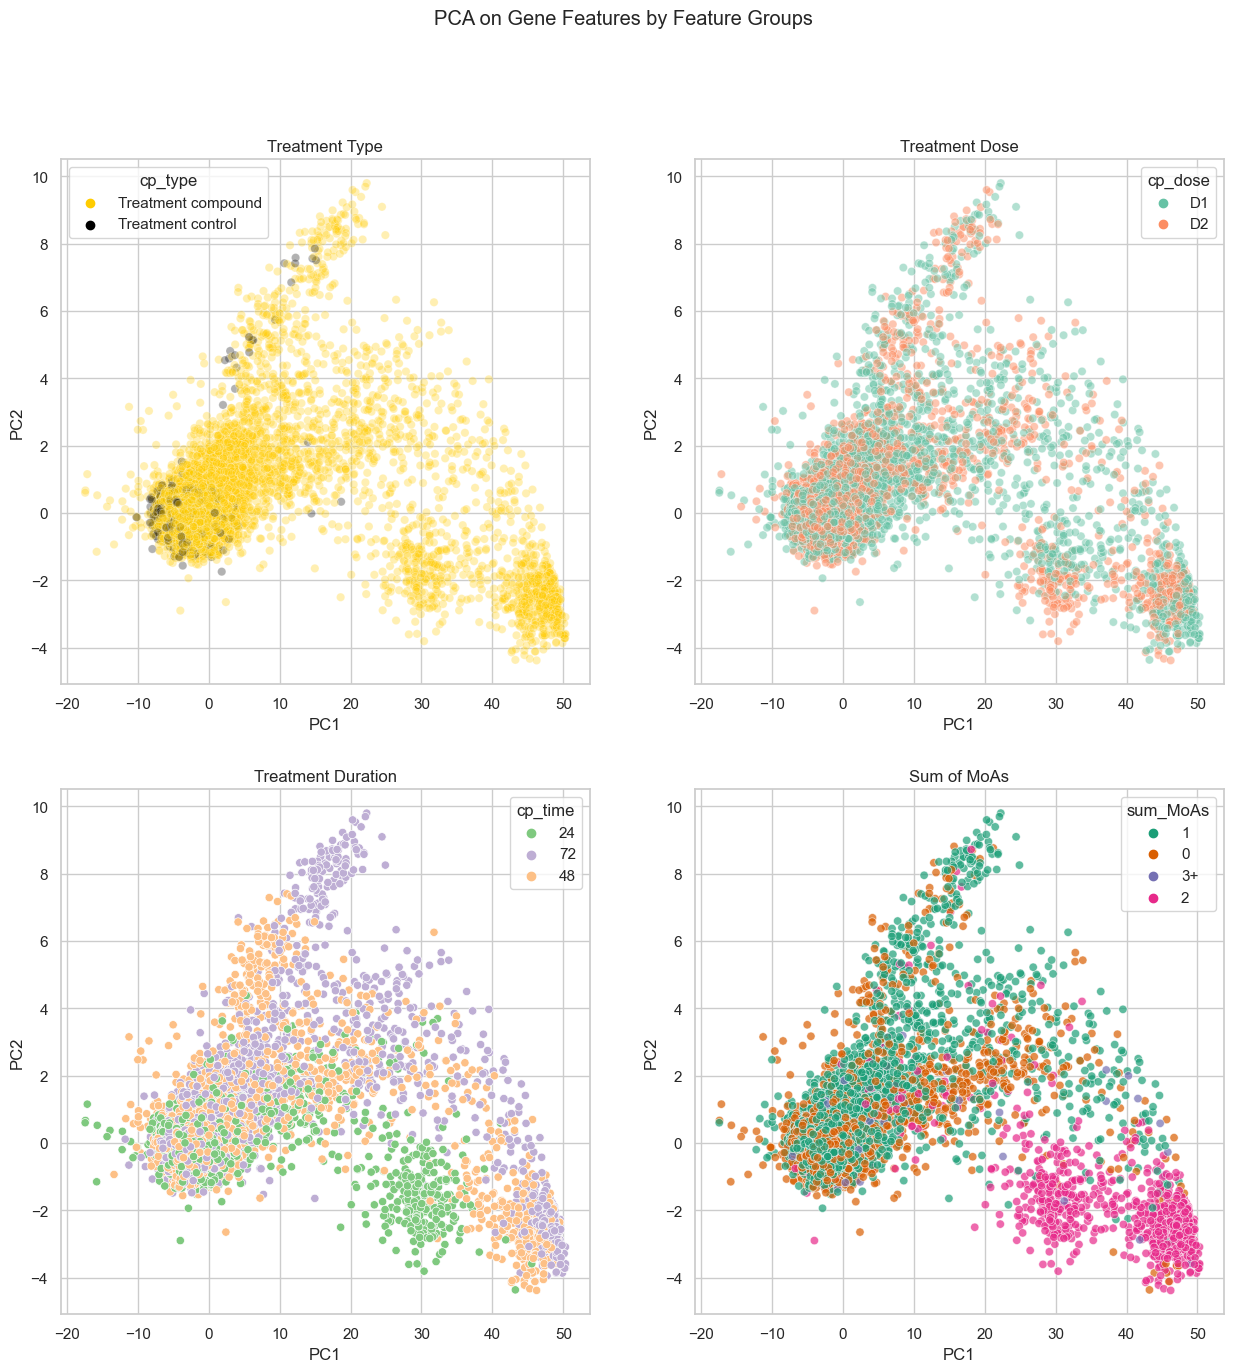

In [33]:
# Prepare the data
X_scaled = StandardScaler().fit_transform(Xc)  # Standardize features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2'])
df_pca['cp_type'] = df_train['cp_type'].map({'trt_cp': 'Treatment compound', 'ctl_vehicle': 'Treatment control'})
df_pca['cp_dose'] = df_train['cp_dose']
df_pca['cp_time'] = df_train['cp_time'].astype(str)

# Assuming you have a way to calculate the 'sum' of MoAs
# For example, if 'sum' is the sum of certain target features
df_pca['sum_MoAs'] = df_train[target_features_scored].sum(axis=1).apply(lambda x: '3+' if x >= 3 else str(x))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Treatment type
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cp_type', alpha=0.3, ax=axs[0, 0], palette=["#FFCC00", "black"])
axs[0, 0].set_title('Treatment Type')

# Treatment dose
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cp_dose', alpha=0.5, ax=axs[0, 1], palette="Set2")
axs[0, 1].set_title('Treatment Dose')

# Treatment duration
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cp_time', alpha=1, ax=axs[1, 0], palette="Accent")
axs[1, 0].set_title('Treatment Duration')

# Sum of MoAs
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sum_MoAs', alpha=0.7, ax=axs[1, 1], palette="Dark2")
axs[1, 1].set_title('Sum of MoAs')

plt.suptitle('PCA on Gene Features by Feature Groups')
plt.show()
